In [ ]:
pip install botorch

**Loading the dataset and cleaning it.**
This Python code uses the pandas library to manipulate a dataset from a CSV file. The dataset is read from the 'Assignment_data.csv' file into a pandas DataFrame named data. The code then selects specific columns, specified by feature_cols (including "Cut Height," "Trim height," and "Trim width") and label_col ("Flight time"). The DataFrame is updated to include only the selected columns, effectively filtering out any unnecessary data. Finally, duplicate rows with the same values in the specified feature columns are removed, ensuring uniqueness in the dataset.

In [ ]:
from typing import Tuple, List
import pandas as pd

DATASET = 'Assignment_data.csv' # Here you can put the dataset exported from excel

data = pd.read_csv(DATASET)

feature_cols = [
    "Cut Height",
    "Trim height",
    "Trim width"
]

label_col = ["Flight time"]

data = data[feature_cols + label_col]
data = data.drop_duplicates(subset=feature_cols)

This Python code utilizes the PyTorch and GPyTorch libraries to define a Gaussian Process (GP) regression model. The `get_gp` function takes input data `X` and corresponding targets `y`, along with specified components for the mean (`mean_module`), covariance (`covar_module`), and likelihood of the GP. It then creates a SingleTaskGP (a type of Gaussian Process model) using these components.

The SingleTaskGP is configured with the provided mean, covariance, and likelihood modules. The `ExactMarginalLogLikelihood` (mll) is also instantiated, serving as the objective function for training the GP. This function is essential for maximizing the likelihood of the observed data under the GP model.

This code is a modular and reusable way to set up a Gaussian Process regression model, allowing users to easily experiment with different mean, covariance, and likelihood functions for various tasks in machine learning, optimization, or Bayesian modeling.

In [ ]:
import torch
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP

# Custom function that creates a GP and mll object from data and model settings
def get_gp(
    X: torch.Tensor,
    y: torch.Tensor,
    mean_module: gpytorch.means.Mean,
    covar_module: gpytorch.kernels.Kernel,
    likelihood: gpytorch.likelihoods.Likelihood
) -> Tuple[
    gpytorch.models.GP,
    gpytorch.mlls.MarginalLogLikelihood
]:
    gp = SingleTaskGP(
        X, y,
        mean_module=mean_module,
        covar_module=covar_module,
        likelihood=likelihood
    )
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    return gp, mll

This code section initializes training and test data splits for a machine learning model. It first sets the variable `test_data` to 5, indicating the number of samples to be used for testing. The `data` DataFrame is then shuffled (`sample(frac=1.)`) to ensure randomness in the dataset.

The features (`X`) and labels (`y`) are extracted from the DataFrame and converted to NumPy arrays. The dataset is split into training and test sets based on the specified `test_data`. The training set (`X_train` and `y_train`) includes all data except the last 5 samples, while the test set (`X_test` and `y_test`) comprises the last 5 samples.

The code prints the shapes of the training and test sets to the console, providing insights into the dataset's structure.

This process is a common practice in machine learning to assess model performance. By splitting the data into training and test sets, it enables the model to learn patterns from the training data and assess its generalization on unseen data, represented by the test set. The shuffle operation ensures a random distribution, reducing the risk of biased training or testing sets.

In [ ]:
# Initialize train/test data
test_data = 5

data = data.sample(frac=1.)

X = data[feature_cols].to_numpy()
y = data[label_col].to_numpy()

X_train = torch.from_numpy(X[:-test_data])
y_train = torch.from_numpy(y[:-test_data])

X_test = torch.from_numpy(X[-test_data:])
y_test = torch.from_numpy(y[-test_data:])

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: torch.Size([9, 3])
Test set: torch.Size([5, 3])


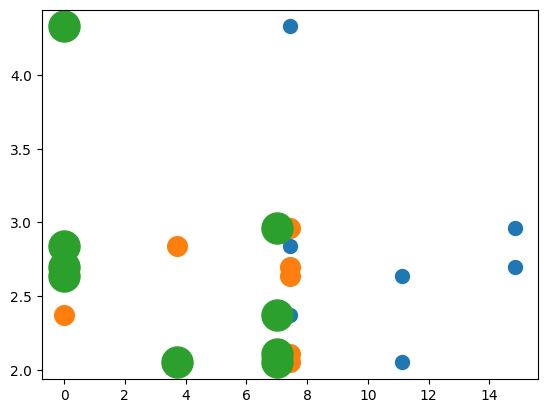

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:,:1], y_train,  s=100, label='Cut Height')
plt.scatter(X_train[:,1:2], y_train, s=200, label='Trim height')
plt.scatter(X_train[:,2:3], y_train, s=500, label='Trim Width')

Creating a cross validation training dataset for optimizing our choice for the GP process and trying different kernels

In [ ]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood

from botorch.fit import fit_gpytorch_mll
from botorch.cross_validation import gen_loo_cv_folds

# Build CV folds
cv_fold = gen_loo_cv_folds(X_train, y_train)

**GP with RBF Kernel**

In [ ]:
KernelRBF = ScaleKernel(RBFKernel())
# Create one single GP in batch mode
gp, mll = get_gp(
    cv_fold.train_X,
    cv_fold.train_Y,
    ConstantMean(),
    KernelRBF,
    GaussianLikelihood()
)

mll = fit_gpytorch_mll(mll)

with torch.no_grad():
    posterior = gp.posterior(cv_fold.test_X)
    mean = posterior.mean

cv_error_RBF = torch.sqrt(((cv_fold.test_Y.squeeze() - mean.squeeze()) ** 2).mean())

print(f"CV RMSE RBF: {cv_error_RBF:.2f}")

CV RMSE RBF: 0.67


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([[2.6762],
        [2.7425],
        [2.7500],
        [2.6513],
        [2.7100],
        [2.6362],
        [2.4650],
        [2.6688],
        [2.7500]], dtype=torch.float64), std = tensor([[0.7598],
        [0.7258],
        [0.7179],
        [0.7570],
        [0.7502],
        [0.7512],
        [0.3686],
        [0.7599],
        [0.7179]], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


**GP with Matern Kernel**

In [ ]:
# Create one single GP in batch mode
gp, mll = get_gp(
    cv_fold.train_X,
    cv_fold.train_Y,
    ConstantMean(),
    ScaleKernel(MaternKernel()),
    GaussianLikelihood()
)

mll = fit_gpytorch_mll(mll)

with torch.no_grad():
    posterior = gp.posterior(cv_fold.test_X)
    mean = posterior.mean

cv_error_matern = torch.sqrt(((cv_fold.test_Y.squeeze() - mean.squeeze()) ** 2).mean())

print(f"CV RMSE Matern: {cv_error_matern:.2f}")

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([[2.6762],
        [2.7425],
        [2.7500],
        [2.6513],
        [2.7100],
        [2.6362],
        [2.4650],
        [2.6688],
        [2.7500]], dtype=torch.float64), std = tensor([[0.7598],
        [0.7258],
        [0.7179],
        [0.7570],
        [0.7502],
        [0.7512],
        [0.3686],
        [0.7599],
        [0.7179]], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


CV RMSE Matern: 0.63


**GP with Matern kernel and nu=2.5**

In [ ]:
# Create one single GP in batch mode
gp, mll = get_gp(
    cv_fold.train_X,
    cv_fold.train_Y,
    ConstantMean(),
    ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=1)),
    GaussianLikelihood()
)

mll = fit_gpytorch_mll(mll)

with torch.no_grad():
    posterior = gp.posterior(cv_fold.test_X)
    mean = posterior.mean

cv_error_matern2 = torch.sqrt(((cv_fold.test_Y.squeeze() - mean.squeeze()) ** 2).mean())

print(f"CV RMSE Matern: {cv_error_matern2 :.2f}")

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([[2.6762],
        [2.7425],
        [2.7500],
        [2.6513],
        [2.7100],
        [2.6362],
        [2.4650],
        [2.6688],
        [2.7500]], dtype=torch.float64), std = tensor([[0.7598],
        [0.7258],
        [0.7179],
        [0.7570],
        [0.7502],
        [0.7512],
        [0.3686],
        [0.7599],
        [0.7179]], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


CV RMSE Matern: 0.63


**GP with Matern kernel and nu=1.5**

In [ ]:
# Create one single GP in batch mode
gp, mll = get_gp(
    cv_fold.train_X,
    cv_fold.train_Y,
    ConstantMean(),
    ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=1)),
    GaussianLikelihood()
)

mll = fit_gpytorch_mll(mll)

with torch.no_grad():
    posterior = gp.posterior(cv_fold.test_X)
    mean = posterior.mean

cv_error_matern1 = torch.sqrt(((cv_fold.test_Y.squeeze() - mean.squeeze()) ** 2).mean())

print(f"CV RMSE Matern: {cv_error_matern1:.2f}")

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([[2.6762],
        [2.7425],
        [2.7500],
        [2.6513],
        [2.7100],
        [2.6362],
        [2.4650],
        [2.6688],
        [2.7500]], dtype=torch.float64), std = tensor([[0.7598],
        [0.7258],
        [0.7179],
        [0.7570],
        [0.7502],
        [0.7512],
        [0.3686],
        [0.7599],
        [0.7179]], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


CV RMSE Matern: 0.64


**Adding the two kernels, RBF and Matern, for the analysis**

In [ ]:
KernelAdd = ScaleKernel(RBFKernel())+ScaleKernel(MaternKernel())

# Create one single GP in batch mode
gp, mll = get_gp(
    cv_fold.train_X,
    cv_fold.train_Y,
    ConstantMean(),
    KernelAdd,
    GaussianLikelihood()
)

mll = fit_gpytorch_mll(mll)

with torch.no_grad():
    posterior = gp.posterior(cv_fold.test_X)
    mean = posterior.mean

cv_error_add = torch.sqrt(((cv_fold.test_Y.squeeze() - mean.squeeze()) ** 2).mean())

print(f"CV RMSE Addition: {cv_error_add:.2f}")

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([[2.6762],
        [2.7425],
        [2.7500],
        [2.6513],
        [2.7100],
        [2.6362],
        [2.4650],
        [2.6688],
        [2.7500]], dtype=torch.float64), std = tensor([[0.7598],
        [0.7258],
        [0.7179],
        [0.7570],
        [0.7502],
        [0.7512],
        [0.3686],
        [0.7599],
        [0.7179]], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


CV RMSE Addition: 0.63


**Multipying the two kernels, RBF and Matern, for the analysis**

In [ ]:
KernelMulti = ScaleKernel(RBFKernel())*ScaleKernel(MaternKernel())

# Create one single GP in batch mode
gp, mll = get_gp(
    cv_fold.train_X,
    cv_fold.train_Y,
    ConstantMean(),
    KernelMulti,
    GaussianLikelihood()
)

mll = fit_gpytorch_mll(mll)

with torch.no_grad():
    posterior = gp.posterior(cv_fold.test_X)
    mean = posterior.mean

cv_error_multi = torch.sqrt(((cv_fold.test_Y.squeeze() - mean.squeeze()) ** 2).mean())

print(f"CV RMSE KernelMultiply: {cv_error_multi:.2f}")

CV RMSE KernelMultiply: 0.67


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([[2.6762],
        [2.7425],
        [2.7500],
        [2.6513],
        [2.7100],
        [2.6362],
        [2.4650],
        [2.6688],
        [2.7500]], dtype=torch.float64), std = tensor([[0.7598],
        [0.7258],
        [0.7179],
        [0.7570],
        [0.7502],
        [0.7512],
        [0.3686],
        [0.7599],
        [0.7179]], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


**Our final choice of GP is the RBF as kernel**

In [ ]:
bounds = torch.tensor([
    [0.1, 0.0, 0.0],
    [14.85, 7.425, 7]
])

# x0 * 1 + x1 *(-1) >= 0.1
ineq_constraint = [(torch.tensor([0, 1], dtype=torch.long), torch.tensor([1, -1], dtype=torch.float), 0.1)]

In the following section, three different acquisition functions are tested: ExpectedImprovement, Probability of Improvement and UCB.

In [ ]:
import numpy as np

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from scipy.spatial.distance import euclidean

    # 1. Create a new GP with the best setup from cross validation
gp, mll = get_gp(
  X_train,
  y_train,
  ConstantMean(),
  ScaleKernel(RBFKernel()),
  GaussianLikelihood()
)

mll = fit_gpytorch_mll(mll)

    # 2. Define and optimize an acquisition function
acq_fun = ExpectedImprovement(model=gp, best_f=torch.max(y_train))
X_new, acqf_val = optimize_acqf(
        acq_function=acq_fun,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=20,
        inequality_constraints=ineq_constraint
    )
X_new_RBF = torch.round(X_new, decimals=1)
acqf_val_RBF= acqf_val
print(X_new, acqf_val_RBF)

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.8822], dtype=torch.float64), std = tensor([0.8880], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[10.4381,  0.8709,  2.3084]]) tensor(0.0014, dtype=torch.float64)


In [ ]:
from botorch.acquisition import ProbabilityOfImprovement

    # 2. Define and optimize an acquisition function
acq_fun = ProbabilityOfImprovement(model=gp, best_f=torch.max(y_train))
X_new, acqf_val = optimize_acqf(
        acq_function=acq_fun,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=20,
        inequality_constraints=ineq_constraint
    )

X_new_POI = torch.round(X_new, decimals=1)
acqf_val_POI= acqf_val
print(X_new, acqf_val_POI)

tensor([[12.8679,  0.7588,  5.6373]]) tensor(0.0072, dtype=torch.float64)


In [ ]:
from botorch.acquisition import UpperConfidenceBound

    # 2. Define and optimize an acquisition function
acq_fun = UpperConfidenceBound(model=gp, beta=0.1)
X_new, acqf_val = optimize_acqf(
        acq_function=acq_fun,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=20,
        inequality_constraints=ineq_constraint
    )
X_new_UCB = torch.round(X_new, decimals=1)
acqf_val_UCB= acqf_val
print(X_new, acqf_val_UCB)

tensor([[7.8302e+00, 6.6236e-03, 3.1090e+00]]) tensor(3.0695, dtype=torch.float64)


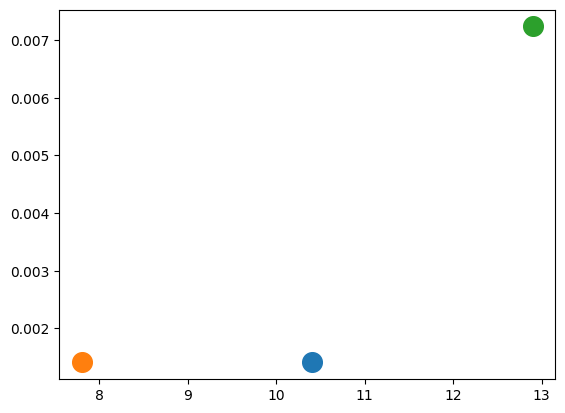

In [ ]:
    plt.scatter(X_new_RBF[:,:1].numpy(), acqf_val_RBF.numpy(), s=200, label=f'{acq_fun} RBF')
    plt.scatter(X_new_UCB[:,:1].numpy(), acqf_val_RBF.numpy(), s=200, label=f'{acq_fun} UCB')
    plt.scatter(X_new_POI[:,:1].numpy(), acqf_val_POI.numpy(), s=200, label=f'{acq_fun} Acquisition')

Final BO LOOP

In [ ]:
import numpy as np

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from scipy.spatial.distance import euclidean

# Simulate BO
for i in range(X_test.shape[0]):

    # 1. Create a new GP with the best setup from cross validation
    gp, mll = get_gp(
        X_train,
        y_train,
        ConstantMean(),
        ScaleKernel(RBFKernel()),
        GaussianLikelihood()
    )

    mll = fit_gpytorch_mll(mll)

    # 2. Define and optimize an acquisition function
    acq_fun = ExpectedImprovement(model=gp, best_f=torch.max(y_train))

    X_new, acqf_val = optimize_acqf(
        acq_function=acq_fun,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=20,
        inequality_constraints=ineq_constraint
    )

    X_new = torch.round(X_new, decimals=1)

    # 3.a (Optional) Find the closes test point
    best_idx = -1
    best_dist = np.inf
    for idx, test_point in enumerate(X_test):
        cur_dist = euclidean(X_new.squeeze(), test_point)
        if cur_dist < best_dist:
            best_dist = cur_dist
            best_idx = idx

    # 3.b Update the dataset by adding the new point
    X_test_new = X_test[best_idx]
    y_test_new = y_test[best_idx]

    # Remove from test set
    X_test = torch.cat((X_test[:best_idx], X_test[best_idx + 1:]))
    y_test = torch.cat((y_test[:best_idx], y_test[best_idx + 1:]))

    print(f"Round: {i}")
    print(f" - New experimental point: {X_new}")
    print(f" - New acquisition value: {acqf_val}")
    print(f" - Test point: {X_test_new}")
    print(f" - Test evaluation: {y_test_new}")
    print(F" - Dataset shape: {X_train.shape[0]}")
    print("")

    X_train = torch.vstack((X_train, X_test_new))
    y_train = torch.vstack((y_train, y_test_new))

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.8822], dtype=torch.float64), std = tensor([0.8880], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 0
 - New experimental point: tensor([[10.9000,  1.3000,  5.5000]])
 - New acquisition value: 0.001410349661947189
 - Test point: tensor([14.8500,  0.0000,  7.0000], dtype=torch.float64)
 - Test evaluation: tensor([3.9400], dtype=torch.float64)
 - Dataset shape: 9



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9880], dtype=torch.float64), std = tensor([0.9016], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 1
 - New experimental point: tensor([[13.1000,  0.5000,  2.0000]])
 - New acquisition value: 0.002801251953991202
 - Test point: tensor([14.8500,  0.0000,  0.0000], dtype=torch.float64)
 - Test evaluation: tensor([3.0900], dtype=torch.float64)
 - Dataset shape: 10



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9973], dtype=torch.float64), std = tensor([0.8559], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 2
 - New experimental point: tensor([[14.6000,  0.6000,  6.8000]])
 - New acquisition value: 0.004328285018625196
 - Test point: tensor([14.8500,  7.4250,  7.0000], dtype=torch.float64)
 - Test evaluation: tensor([2.9600], dtype=torch.float64)
 - Dataset shape: 11



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9942], dtype=torch.float64), std = tensor([0.8161], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 3
 - New experimental point: tensor([[14.8000,  0.6000,  6.7000]])
 - New acquisition value: 0.003213948170079948
 - Test point: tensor([7.4250, 7.4250, 7.0000], dtype=torch.float64)
 - Test evaluation: tensor([2.1100], dtype=torch.float64)
 - Dataset shape: 12



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9262], dtype=torch.float64), std = tensor([0.8190], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 4
 - New experimental point: tensor([[7.4000, 0.0000, 0.0000]])
 - New acquisition value: 0.00583971635215427
 - Test point: tensor([11.1375,  7.4250,  0.0000], dtype=torch.float64)
 - Test evaluation: tensor([2.6400], dtype=torch.float64)
 - Dataset shape: 13



Adding the datapoints and experimental data collected ater running the BO loop first time. Results are not reproducible since intiial traing set is randomly shuffled each time the file is run.

In [ ]:
#array1 = np.array([10.2000, 9.1000, 1.4000])
array2 = np.array([9.3000, 1.2000, 1.8000])
#array3 = np.array([7.6,	5.4,	0.37])
array4 = np.array([7.9,	0.7,	0.1])
array11= np.array([9.1,	0.,	0.])
#array5 = np.array([3.77])
array6 = np.array([4.00])
#array7 = np.array([2.96])
array8 = np.array([3.68])
array12= np.array([4.67])

# Vertical stack
X_test = np.vstack((X_test, array11, array2,  array4))
y_test = np.vstack((y_test, array12, array6,  array8))
print(type(X_test))
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

<class 'numpy.ndarray'>


BO loop with new experimental points and flight time recorded.

In [ ]:
import numpy as np

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from scipy.spatial.distance import euclidean

# Simulate BO
for i in range(X_test.shape[0]):

    # 1. Create a new GP with the best setup from cross validation
    gp, mll = get_gp(
        X_train,
        y_train,
        ConstantMean(),
        ScaleKernel(RBFKernel()),
        GaussianLikelihood()
    )

    mll = fit_gpytorch_mll(mll)

    # 2. Define and optimize an acquisition function
    acq_fun = ExpectedImprovement(model=gp, best_f=torch.max(y_train))

    X_new, acqf_val = optimize_acqf(
        acq_function=acq_fun,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=20,
        inequality_constraints=ineq_constraint
    )

    X_new = torch.round(X_new, decimals=1)

    # 3.a (Optional) Find the closes test point
    best_idx = -1
    best_dist = np.inf
    for idx, test_point in enumerate(X_test):
        cur_dist = euclidean(X_new.squeeze(), test_point)
        if cur_dist < best_dist:
            best_dist = cur_dist
            best_idx = idx

    # 3.b Update the dataset by adding the new point
    X_test_new = X_test[best_idx]
    y_test_new = y_test[best_idx]

    # Remove from test set
    X_test = torch.cat((X_test[:best_idx], X_test[best_idx + 1:]))
    y_test = torch.cat((y_test[:best_idx], y_test[best_idx + 1:]))

    print(f"Round: {i}")
    print(f" - New experimental point: {X_new}")
    print(f" - New acquisition value: {acqf_val}")
    print(f" - Test point: {X_test_new}")
    print(f" - Test evaluation: {y_test_new}")
    print(F" - Dataset shape: {X_train.shape[0]}")
    print("")

    X_train = torch.vstack((X_train, X_test_new))
    y_train = torch.vstack((y_train, y_test_new))

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([2.9057], dtype=torch.float64), std = tensor([0.7905], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 0
 - New experimental point: tensor([[11.1000,  0.3000,  0.1000]])
 - New acquisition value: 0.004766784527547638
 - Test point: tensor([9.1000, 0.0000, 0.0000], dtype=torch.float64)
 - Test evaluation: tensor([4.6700], dtype=torch.float64)
 - Dataset shape: 14



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0233], dtype=torch.float64), std = tensor([0.8876], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 1
 - New experimental point: tensor([[1.8000, 0.3000, 3.7000]])
 - New acquisition value: 0.0005018686863872114
 - Test point: tensor([7.9000, 0.7000, 0.1000], dtype=torch.float64)
 - Test evaluation: tensor([3.6800], dtype=torch.float64)
 - Dataset shape: 15



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([3.0644], dtype=torch.float64), std = tensor([0.8731], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Round: 2
 - New experimental point: tensor([[10.7000,  1.1000,  0.5000]])
 - New acquisition value: 0.00020863233449624393
 - Test point: tensor([9.3000, 1.2000, 1.8000], dtype=torch.float64)
 - Test evaluation: tensor([4.], dtype=torch.float64)
 - Dataset shape: 16



print(X_train, y_train, X_test, y_test)

In [ ]:
y_test

tensor([], size=(0, 1), dtype=torch.float64)